# Convolutional Neural Network for Emotion Recognition

## Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

import shutil
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import random
import opendatasets as od 

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Semillas para reproducibilidad
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)


Usando dispositivo: cuda


## Filtrado y carga dataset

In [18]:

dataset_url = "https://www.kaggle.com/datasets/samithsachidanandan/human-face-emotions"
od.download(dataset_url)


dataset_path = Path("human-face-emotions") / "Data"
filtered_path = Path("human-face-emotions-filtered")


categories = ["Angry", "Fear", "Happy", "Sad", "Suprise"]

def filtrar_dataset_aleatorio(dataset_path, filtered_path, categories, max_imgs=5000):
    if filtered_path.exists():
        shutil.rmtree(filtered_path)
    filtered_path.mkdir(parents=True, exist_ok=True)

    for cat in categories:
        imgs = list((dataset_path / cat).glob('*.jpg')) + list((dataset_path / cat).glob('*.jpeg')) + list((dataset_path / cat).glob('*.png'))
        imgs_sample = random.sample(imgs, min(len(imgs), max_imgs))

        cat_filtered_dir = filtered_path / cat
        cat_filtered_dir.mkdir(exist_ok=True)

        for img in imgs_sample:
            shutil.copy(img, cat_filtered_dir / img.name)

    print("Filtrado completo. Subset creado en:", filtered_path)

# Ejecutamos el filtrado
filtrar_dataset_aleatorio(dataset_path, filtered_path, categories)


Skipping, found downloaded files in ".\human-face-emotions" (use force=True to force download)
Filtrado completo. Subset creado en: human-face-emotions-filtered


## Divisiones y transformaciones datos

In [19]:
# Definimos transformaciones para entrenamiento (incluye data augmentation) y para validación/test
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root=str(filtered_path))

# Para dividir dataset, creamos índices aleatorios reproducibles
np.random.seed(SEED)
indices = np.arange(len(full_dataset))
np.random.shuffle(indices)

# Definimos porcentajes
train_percent = 0.8
test_val_percent = 0.1

train_idx_end = int(train_percent * len(full_dataset))
test_val_idx_end = int((train_percent + test_val_percent) * len(full_dataset))

# Clase wrapper para aplicar transformaciones diferentes a subsets
class TransformedSubset:
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)

# Creamos subsets con transformación específica
dataset_train = TransformedSubset(Subset(full_dataset, indices[:train_idx_end]), transform_train)
dataset_val = TransformedSubset(Subset(full_dataset, indices[train_idx_end:test_val_idx_end]), transform_test_val)
dataset_test = TransformedSubset(Subset(full_dataset, indices[test_val_idx_end:]), transform_test_val)

# DataLoaders, con batch size 16 (ajustable), shuffle para train y val
train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False)


## Definición modelo CNN

Esta arquitectura tiene 3 bloques convolucionales con activaciones ReLU, max pooling, y dropout para regularización. Después, tiene dos capas completamente conectadas para clasificación en las 5 categorías. El tamaño de la capa fully connected de entrada se calcula considerando 3 reducciones por max pooling (factor 8 reducción lineal en imagen 224x224).

In [20]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(EmotionCNN, self).__init__()
        
        # Bloque Conv 1: entrada 3 canales (RGB)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
        # Bloque Conv 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Bloque Conv 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Capa completamente conectada
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # 224x224 input -> 28x28 tras 3 pool
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = EmotionCNN(num_classes=len(categories)).to(device)
print(model)


EmotionCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)


In [ ]:
# Parámetros de entrenamiento
learning_rate = 0.001
num_epochs = 30
patience = 5  # Paciencia para early stopping

# Optimizer y función de pérdida
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Early stopping variables
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

# Función para entrenar un epoch
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Función para evaluar en validación/test
def eval_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


## Ciclo de entrenamiento

In [21]:
# Inicializamos listas para guardar métricas
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
epochs_no_improve = 0
patience = 5
early_stop = False

for epoch in range(num_epochs):
    # Entrenar un epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    # Validar un epoch
    val_loss, val_acc = eval_model(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
          f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Se detiene el entrenamiento por early stopping")
            early_stop = True
            break

# Carga el mejor modelo guardado
model.load_state_dict(torch.load("best_model.pt"))


Epoch 1/100 - Train loss: 1.6106, Train acc: 0.1895, Val loss: 1.6092, Val acc: 0.2148
Epoch 2/100 - Train loss: 1.6109, Train acc: 0.1832, Val loss: 1.6092, Val acc: 0.2148
Epoch 3/100 - Train loss: 1.6107, Train acc: 0.1865, Val loss: 1.6092, Val acc: 0.2148
Epoch 4/100 - Train loss: 1.6108, Train acc: 0.1860, Val loss: 1.6092, Val acc: 0.2148
Epoch 5/100 - Train loss: 1.6106, Train acc: 0.1865, Val loss: 1.6092, Val acc: 0.2148
Epoch 6/100 - Train loss: 1.6108, Train acc: 0.1872, Val loss: 1.6092, Val acc: 0.2148
Epoch 7/100 - Train loss: 1.6105, Train acc: 0.1930, Val loss: 1.6092, Val acc: 0.2148
Se detiene el entrenamiento por early stopping


<All keys matched successfully>

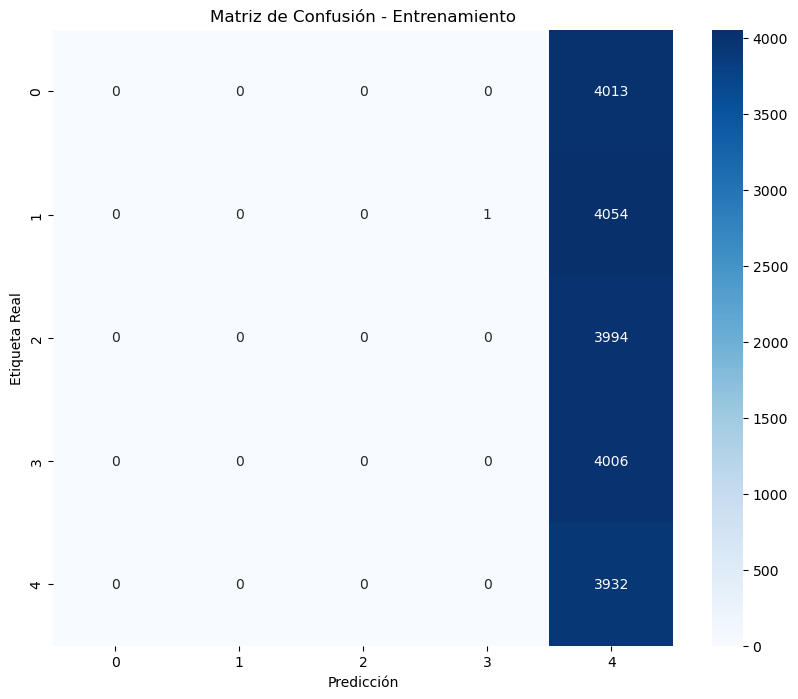

In [22]:

model.eval()
all_preds_train = []
all_labels_train = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds_train.extend(predicted.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

conf_matrix_train = confusion_matrix(all_labels_train, all_preds_train)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()


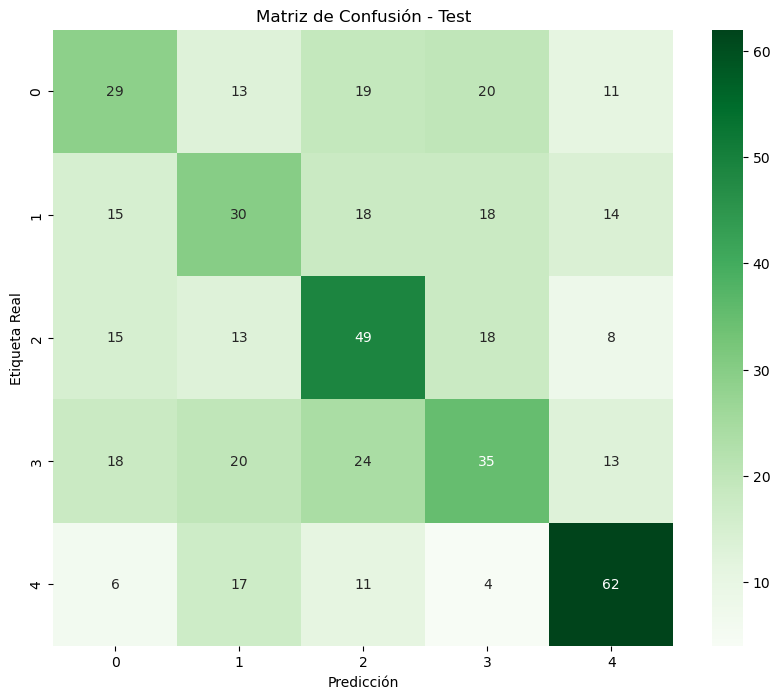

In [10]:
model.eval()
all_preds_test = []
all_labels_test = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds_test.extend(predicted.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

conf_matrix_test = confusion_matrix(all_labels_test, all_preds_test)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Test')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()


In [11]:
correct = 0
total = 0

model.eval()
with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the {total} test images: {100 * correct / total:.2f}%')


Accuracy of the model on the 500 test images: 41.00%


In [12]:
from sklearn.metrics import classification_report

print("Reporte de clasificación para el conjunto de test:")
print(classification_report(all_labels_test, all_preds_test, target_names=categories))


Reporte de clasificación para el conjunto de test:
              precision    recall  f1-score   support

       Angry       0.35      0.32      0.33        92
        Fear       0.32      0.32      0.32        95
       Happy       0.40      0.48      0.44       103
         Sad       0.37      0.32      0.34       110
     Suprise       0.57      0.62      0.60       100

    accuracy                           0.41       500
   macro avg       0.40      0.41      0.41       500
weighted avg       0.40      0.41      0.41       500



## Visualización de la evolución de entrenamiento y validación


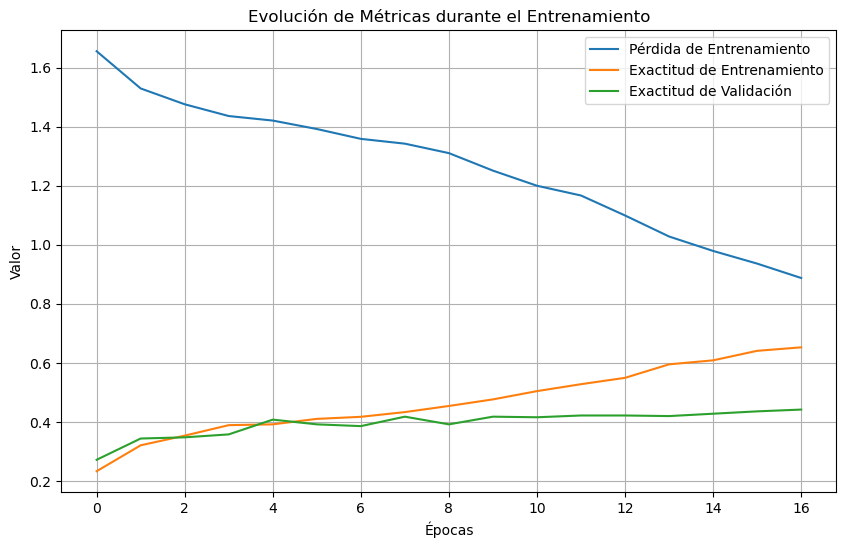

In [13]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(train_accuracies, label='Exactitud de Entrenamiento')
plt.plot(val_accuracies, label='Exactitud de Validación')
plt.xlabel('Épocas')
plt.ylabel('Valor')
plt.title('Evolución de Métricas durante el Entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
torch.save(model.state_dict(), 'modelo_emociones.pth')
print("Modelo guardado como 'modelo_emociones.pth'")


Modelo guardado como 'modelo_emociones.pth'
